In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Import data

In [18]:
# lower granite
lower_granite_inflow = pd.read_csv('lowergraniteinflow.csv')
lower_granite_storage = pd.read_csv('lowergranitestorage.csv')
lower_granite_outflows = pd.read_csv('lowergraniteoutflow.csv')
lower_granite_data = lower_granite_inflow.merge(lower_granite_storage, how='inner', on=['date'])
lower_granite_data = lower_granite_data.merge(lower_granite_outflows, how='inner', on=['date'])
lower_granite_data['L (unit:cfs)'] = 0 #no lower granite trib data
lower_granite_data['date'] = pd.to_datetime(lower_granite_data['date'])

# little goose
little_goose_data = pd.read_csv('littlegoosestorage.csv')
little_goose_data['L (unit:cfs)'] = 0 #NO TRIB DATA FOR LITTLE GOOSE
little_goose_data['date'] = pd.to_datetime(little_goose_data['date'])

# lower monumental
lower_monumental_storage = pd.read_csv('lowermonumentalstorage.csv')
lower_monumental_trib = pd.read_csv('lowermontrib.csv')
lower_monumental_trib['L (unit:cfs)'] = lower_monumental_trib['L (unit:cfs)'].clip(lower=0)
lower_monumental_data = lower_monumental_trib.merge(lower_monumental_storage, how='inner', on=['date'])
lower_monumental_data['date'] = pd.to_datetime(lower_monumental_data['date'])

# ice harbor
ice_harbor_storage = pd.read_csv('iceharborstorage.csv')
ice_harbor_trib = pd.read_csv('iceharbortrib.csv')
ice_harbor_trib['L (unit:cfs)'] = ice_harbor_trib['L (unit:cfs)'].clip(lower=0)
ice_harbor_data = ice_harbor_trib.merge(ice_harbor_storage, how='inner', on=['date'])
ice_harbor_data['date'] = pd.to_datetime(ice_harbor_data['date'])

## Initialize reservoirs

In [19]:
from Reservoir4 import Reservoir

ice_harbor = Reservoir(SA=9200*4047,num_turb=6,capacity=603000,tail_elev=339,pool_elev=446,bottom_elev=310,fish_pass=0.965, area=550_000_000, pc=106_000, spillway_cap=850_000)
lower_monumental = Reservoir(SA=6590*4047,num_turb=6,capacity=810000,tail_elev=439,pool_elev=548.3,bottom_elev=406,fish_pass=0.965, area=1_610_000_000, pc=130_000, spillway_cap=850_000)
little_goose = Reservoir(SA=10025*4047,num_turb=6,capacity=903000,tail_elev=539,pool_elev=646.5,bottom_elev=500,fish_pass=0.9775, area=1_175_000_000, pc=130_000, spillway_cap=850_000)
lower_granite = Reservoir(SA=8900*4047,num_turb=6,capacity=810000,tail_elev=636,pool_elev=746.5,bottom_elev=590,fish_pass=1, area=2_477_000_000, pc=130_000, spillway_cap=850_000)

## Simulate storage with Stefano's function

Min: 11170
Max: 231866
Mean: 48911.7


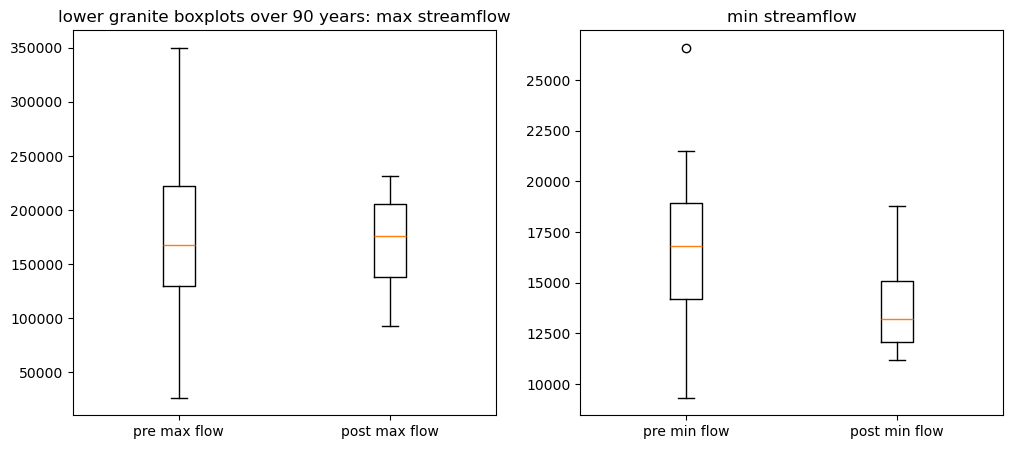

In [20]:
pre_cutoff = datetime(1970,1,1)
lower_granite_pre = lower_granite_data[lower_granite_data['date'] <= pre_cutoff]
lower_granite_pre_max = lower_granite_pre.groupby(lower_granite_pre['date'].dt.year)['H (unit:cfs)'].max()
lower_granite_pre_min = lower_granite_pre.groupby(lower_granite_pre['date'].dt.year)['H (unit:cfs)'].min()

post_cutoff = datetime(1993,1,1)
lower_granite_post = lower_granite_data[lower_granite_data['date'] >= post_cutoff]
lower_granite_post_max = lower_granite_post.groupby(lower_granite_post['date'].dt.year)['H (unit:cfs)'].max()
lower_granite_post_min = lower_granite_post.groupby(lower_granite_post['date'].dt.year)['H (unit:cfs)'].min()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.boxplot([lower_granite_pre_max, lower_granite_post_max], tick_labels=['pre max flow', 'post max flow'])
plt.title('lower granite boxplots over 90 years: max streamflow')

plt.subplot(1,2,2)
plt.boxplot([lower_granite_pre_min, lower_granite_post_min], tick_labels=['pre min flow', 'post min flow'])
plt.title('min streamflow')

outflows = lower_granite_post['H (unit:cfs)']
print(f'Min: {np.min(outflows)}')
print(f'Max: {np.max(outflows)}')
print(f'Mean: {np.mean(outflows):0.1f}')

/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_59032/4209666277.py:10: RuntimeWarning: invalid value encountered in power
  r_test_nat = np.where(h_test > h0, beta * (h_test - h0) ** alfa, 0)
/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:104: RuntimeWarning: invalid value encountered in power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)


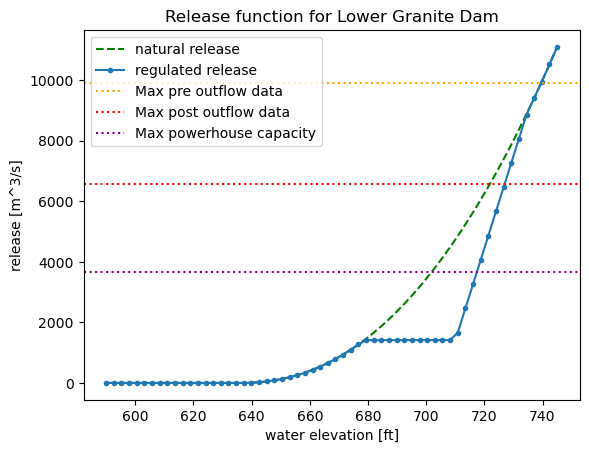

In [21]:
# Define the range of water levels
h_test = np.arange(590*0.3046, 746.5*0.3046, 0.8) # range of heights in ft

param = {'beta':5, 'alfa':2.2, 'h0': 636*0.3046, 'mef':50000*(0.3046**3), 'h1':710*0.3046, 'm':1000}
h0 = param['h0']
beta = param['beta']
alfa = param['alfa']

# Calculate the natural release
r_test_nat = np.where(h_test > h0, beta * (h_test - h0) ** alfa, 0)

# calculate regulated release
r_test_reg = lower_granite.regulated_release(param, h_test)

plt.figure()
plt.plot(h_test/0.3046, r_test_nat, 'g--', label='natural release')
plt.plot(h_test/0.3046, r_test_reg, '.-', label='regulated release')
plt.axhline(350_000*0.0283, color='orange', linestyle=':', label='Max pre outflow data')
plt.axhline(231_866*0.0283, color='r', linestyle=':', label='Max post outflow data')
plt.axhline(130_000*0.0283, color='purple', linestyle=':', label='Max powerhouse capacity')
plt.xlabel('water elevation [ft]')
plt.ylabel('release [m^3/s]')
plt.title('Release function for Lower Granite Dam')
plt.legend()

<Axes: xlabel='date', ylabel='A (unit:cfs)'>

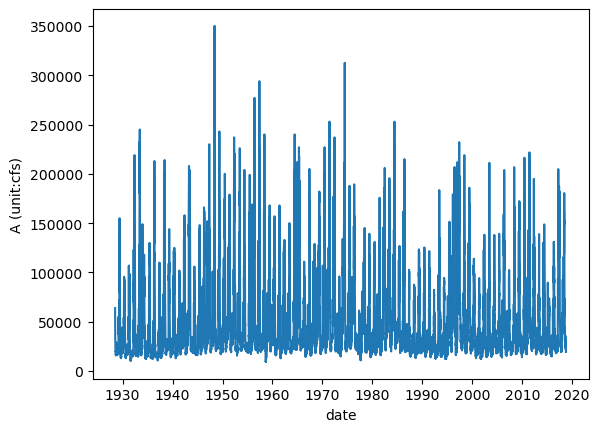

In [22]:
#plot LGR inflow
sns.lineplot(x='date', y='A (unit:cfs)', data=lower_granite_data)

Text(0.5, 1.0, 'Lower Granite outflow (regulated release function)')

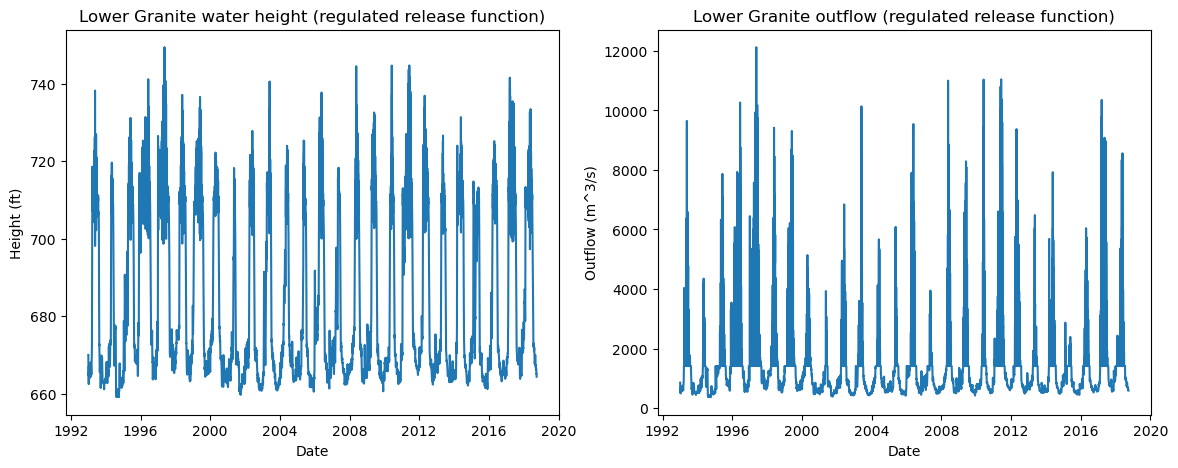

In [23]:
param = {'beta':5, 'alfa':2.2, 'h0': 636*0.3046, 'mef':50000*(0.3046**3), 'h1':710*0.3046, 'm':1000}
keep = 1
initial_level = 670*0.3046 # m
prev_out = lower_granite_data['A (unit:cfs)'][lower_granite_data['date'] >= post_cutoff]
tributary = lower_granite_data['L (unit:cfs)'][lower_granite_data['date'] >= post_cutoff]
inflow = (prev_out + tributary)*0.0283 # inflow, in m^3/s

storage, height, outflow_reg = lower_granite.simulation_reg_lake(param, initial_level, inflow.values)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Lower Granite water height (regulated release function)')

plt.subplot(1,2,2)
plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], outflow_reg)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/s)')
plt.title('Lower Granite outflow (regulated release function)')

Text(0.5, 1.0, 'Lower Granite outflow (natural release function)')

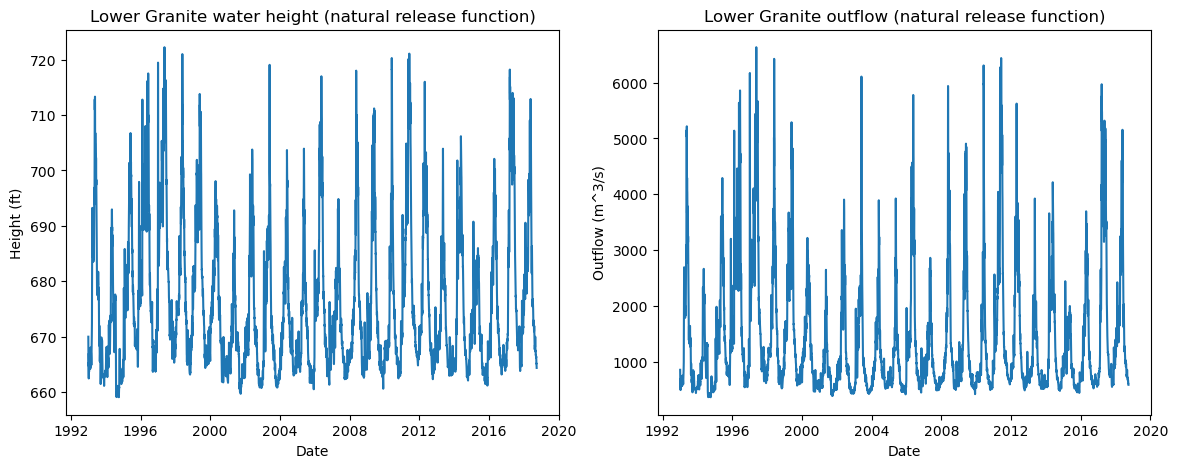

In [24]:
param = {'beta':5, 'alfa':2.2}
keep = 1
initial_level = 670*0.3046 # m
prev_out = lower_granite_data['A (unit:cfs)'][lower_granite_data['date'] >= post_cutoff]
tributary = lower_granite_data['L (unit:cfs)'][lower_granite_data['date'] >= post_cutoff]
inflow = (prev_out + tributary)*0.0283 # inflow, in m^3/s

storage, height, outflow = lower_granite.simulation_nat_lake(keep, param, initial_level, inflow.values)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Lower Granite water height (natural release function)')

plt.subplot(1,2,2)
plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], outflow)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/s)')
plt.title('Lower Granite outflow (natural release function)')

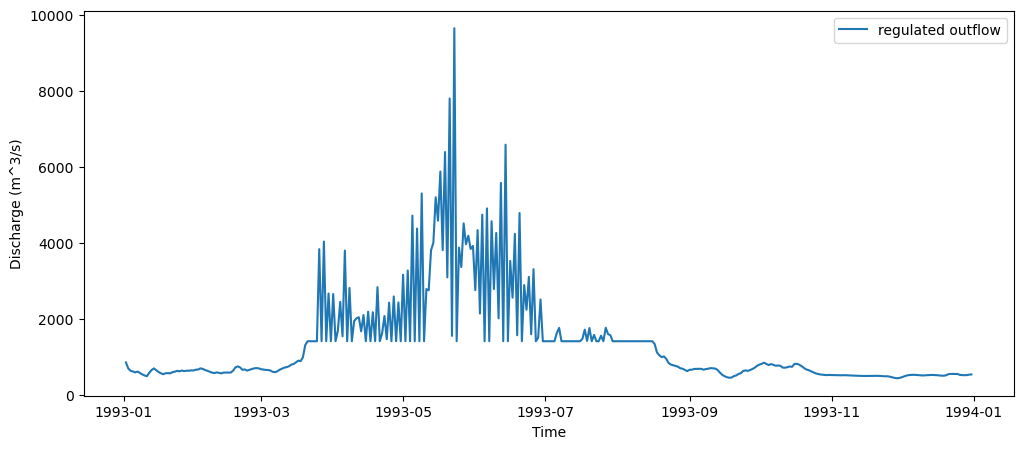

In [31]:
plt.figure(figsize=(12,5))

plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff][:365], outflow_reg[:365], label='regulated outflow')
#plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], outflow, label='"natural" outflow')
#plt.plot(lower_granite_data['date'][lower_granite_data['date'] >= post_cutoff], inflow, label='inflow')

plt.xlabel('Time')
plt.ylabel('Discharge (m^3/s)')
plt.legend()